In [53]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import glob
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from keras.models import Sequential
from tensorflow.keras import layers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix

### Loading Dataset
Since our dataset is seperated by training, validation and testing.

**Training data** builds the machine learning model. It teaches what the expected output looks like.

**Validation data** provides an unbiased evaluation of a model fit on the training data set

**Test data** is a dataset used to provide an unbiased evaluation of a final model fit on the training data set

In [3]:
#setting up directory's

#Train Image Directory
train_dir = 'images/Train_Images/'

#Test Images Directory
test_dir = 'images/Test_Images'


### Visualization of dataset ###

First we define a function called load_dataset, the purpose here is to help us then create a sample DataFrame which will then be used to load a sample image.

Next, I also use a data visualization tool called seaborn, to look at the distribution of the dataset. Ensure data is equally distributed. If not, additionally preprocessing will need to be done before getting started

In [4]:
#defining function to load datasets for visualization purposes
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [5]:
#Creating Sample Training dataFrame for image visualization
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(train_dir)
train.head()

LGSC Completed
HGSC Completed
EC Completed
MC Completed
CC Completed


,image,label
0,images/Train_Images/LGSC/3975.png,LGSC
1,images/Train_Images/LGSC/14392.png,LGSC
2,images/Train_Images/LGSC/15932.png,LGSC
3,images/Train_Images/LGSC/20751.png,LGSC
4,images/Train_Images/LGSC/20745.png,LGSC


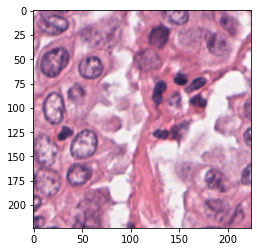

In [6]:
#Loading sample image from training dataset
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open(train['image'][12])
plt.imshow(img)

<AxesSubplot:xlabel='label', ylabel='count'>

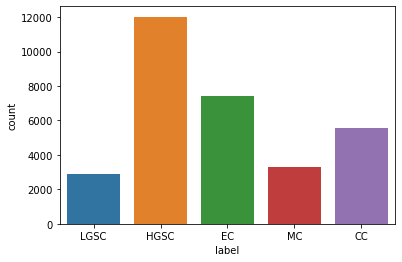

In [7]:
import seaborn as sns


#Performing data visualization on image distribution. 
sns.countplot(train['label'])

In [28]:
#Class Distribution pre-SMOTE
images = train['label']

print('Original class distribution: \n')
print(images.value_counts())
print(images.value_counts(normalize = True))

Original class distribution: 

HGSC    12019
EC       7421
CC       5579
MC       3276
LGSC     2908
Name: label, dtype: int64
HGSC    0.385187
EC      0.237830
CC      0.178797
MC      0.104990
LGSC    0.093196
Name: label, dtype: float64


### Oh No There is class imbalance!
As we first see, there is a class imbalance, some classes have more than others. This will affect our results. We will have to fix later


### Creating  Training dataset ### 
 To save memory, and speed up process.. I will be using only 500 images from each class. 

In [41]:
import cv2
images_list = []
label_list = []
labels = []
train_images = os.listdir(train_dir)
for i in range(len(train_images)):
    print(str((i/len(train_images))*100)+'%',end='\r',flush=True)
    images = os.listdir(train_dir+train_images[i])
    label_list.append(train_images[i])
    for j in range(500):
        image = cv2.imread(train_dir+train_images[i]+'/'+images[j])
        images_list.append(image)
        labels.append(i)
train_list = np.array(images_list)/255
label_list = np.array(label_list)
labels = np.array(labels)
print(train_list.shape)
print(label_list)
print(labels)

(2500, 224, 224, 3)
['LGSC' 'HGSC' 'EC' 'MC' 'CC']
[0 0 0 ... 4 4 4]


## Creating Test Validation Dataset

In [65]:
#Test Images Directory
test_dir = 'images/Test_Images'

#Loading Test dataset as test_x
test_x = []
for folder in os.listdir(test_dir):
    sub_path=test_dir+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        test_x.append(img_arr)

In [66]:
#converting into numpy array
x_test = np.array(test_x)

x_test = x_test/255.0

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Instantiating the ImageDataGenerator
datagen = ImageDataGenerator(rescale = 1./255)

#Using ImageDataGenerator To create and load classes
test_set = datagen.flow_from_directory(test_dir,
                                            target_size = (180,180),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 3082 images belonging to 5 classes.


In [68]:
test_set.class_indices

{'CC': 0, 'EC': 1, 'HGSC': 2, 'LGSC': 3, 'MC': 4}

In [70]:
#Setting the classes
y_test=test_set.classes

y_test.shape

(3082,)

### Building the Model
I will be using a **Sequential Model** here first, to build the Convolutional Neural Network or CNN model which will be used.

Then the following layers are added

**Conv2D** (e.g. spatial convolution over images). This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

**MaxPooling2D** This passes a moving window over the image and downscales the image by outputting the maximum value within the window

**Dropout** Used to prevent overfitting of data

**Flatten** flattens the output from the convolutional part of the CNN into a one-dimensional feature vector which can be passed into the following fully connected layers.

**Dense** Fully connected layer where every input is connected to every output

In [54]:
#Instantiating our model with rescaling
model = Sequential([layers.Rescaling(1./255, input_shape=(224,224,3))])

num_classes = 5

#Adding Layers
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Flatten())

#fully connected layer

model.add(Dense(128, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(256, kernel_initializer = 'uniform', activation='relu'))
model.add(Dense(256, kernel_initializer = 'uniform', activation='relu'))
#prediction layer
model.add(Dense(num_classes, activation='softmax', name = 'preds'))

In [55]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 112, 112, 3)       0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 112, 112, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                      

## Compiling & Fitting the model

When compiling the model, we introduce a learning rate of 0.001, to increase accuracy when training the model.

The **Adam** will be used as an Optimizer.

The Loss will **tf.keras.losses.SparseCategoricalCrossentropy** which Computes the crossentropy loss between the labels and predictions, we also use it with from_logits=True since the model provides a linear output.

When fitting the model, I use 10 epochs.

Validation dataset is included as a parameter under validation_data.

In [56]:
#setting parameters for base rate
base_learning_rate = 0.001

#Compiling the model
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:

#Number of Epochs used in training
epochs = 10


#Fitting the data and running our model
main_history = model.fit(train_list, 
                         labels,
                         validation_data = (x_test, y_test),
                        epochs= epochs)

Epoch 1/10
79/79 [==============================] - 233s 3s/step - loss: 0.2613 - accuracy: 0.9068 - val_loss: 4.2813 - val_accuracy: 0.3206
Epoch 2/10
79/79 [==============================] - 136s 2s/step - loss: 0.2931 - accuracy: 0.9012 - val_loss: 4.5462 - val_accuracy: 0.2398
Epoch 3/10
79/79 [==============================] - 109s 1s/step - loss: 0.2686 - accuracy: 0.9100 - val_loss: 3.7216 - val_accuracy: 0.3011
Epoch 4/10
79/79 [==============================] - 101s 1s/step - loss: 0.2491 - accuracy: 0.9112 - val_loss: 4.7273 - val_accuracy: 0.2148
Epoch 5/10
79/79 [==============================] - 102s 1s/step - loss: 0.1589 - accuracy: 0.9448 - val_loss: 5.9370 - val_accuracy: 0.2628
Epoch 6/10
79/79 [==============================] - 102s 1s/step - loss: 0.2141 - accuracy: 0.9308 - val_loss: 4.5875 - val_accuracy: 0.2855
Epoch 7/10
79/79 [==============================] - 104s 1s/step - loss: 0.1676 - accuracy: 0.9412 - val_loss: 5.2590 - val_accuracy: 0.2777
Epoch 8/10
79

In [73]:
acc = main_history.history['accuracy']
val_acc = main_history.history['val_accuracy']
loss = main_history.history['loss']
val_loss = main_history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

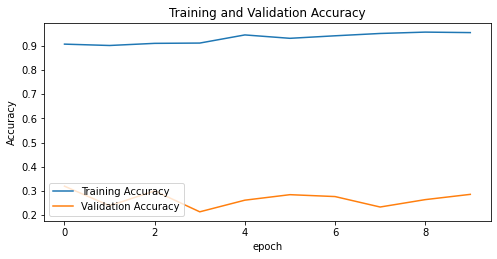

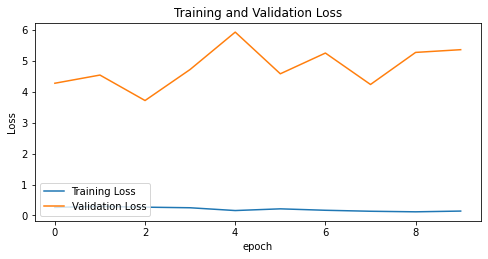

In [74]:
#Visualization for Training and Validation Accuracy
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label = 'Training Accuracy')
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend(loc = "lower left")
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.title("Training and Validation Accuracy")

#Data Visualization for Training and Validation Loss
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = "Validation Loss")
plt.legend(loc = "lower left")
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title("Training and Validation Loss")

In [76]:
#Model Evaluation

# evaluate model on test set
score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


# evaluate model on training set
eval_score = model.evaluate(train_list)
# print loss score
print('Eval loss:', eval_score[0])
# print accuracy score
print('Eval accuracy:', eval_score[1])

97/97 [==============================] - 31s 308ms/step - loss: 5.3680 - accuracy: 0.2868
Test loss: 5.368046760559082
Test accuracy: 0.2868267297744751
79/79 [==============================] - 9s 91ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Eval loss: 0.0
Eval accuracy: 0.0


In [77]:
#prediction on test set
raw_score_predictions = model.predict(x_test)
predictions = np.argmax(raw_score_predictions, axis =-1)

97/97 [==============================] - 32s 309ms/step


In [78]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.22      0.30      0.25       551
           1       0.30      0.53      0.38       733
           2       0.45      0.18      0.25      1188
           3       0.12      0.02      0.04       287
           4       0.22      0.34      0.27       323

    accuracy                           0.29      3082
   macro avg       0.26      0.28      0.24      3082
weighted avg       0.32      0.29      0.27      3082



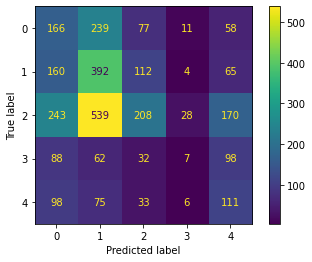

In [79]:
#Creating Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, predictions)